<center> <h1>TikTok Data Parsing</h1> </center>

## Imports

In [1]:
# General data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from wordcloud import WordCloud

# For text analysis
import re
import emoji
import spacy
import nltk
from nltk.corpus import stopwords
from textblob import Word

nltk.download('stopwords')

# For network stuff
import networkx as nx
from networkx.algorithms import community

## Parameters

In [109]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.style.use('bmh')

## Definitions

In [2]:
# pro BLM hashtags

hashtags_pro_sure = ['blacklivesmattermovement', 'alllivesmatterwhenblacklivesmatter', 
                     'blacklivesmatterally', 'justiceforgeorgefloyd']

hashtags_pro_prob = ['blacklivesmatter', 'blm', 'georgefloyd', 'breonnataylor']

hashtags_pro = hashtags_pro_sure + hashtags_pro_prob


hashtags_con_sure = ['alllivesmatternotjustblacklives', 'bluelivesmatter', 
                     'alllivesmattertrump2020', 'policelivesmatter', 'whitelivesmatter']

hashtags_con_prob = ['alllivesmatter', 'backtheblue']

hashtags_con = hashtags_con_sure + hashtags_con_prob


hashtags_boost = ['fyp', 'foryou', 'foryoupage', 'viral', 'xyzbca', 'fypシ', 
                 'fy', 'foryourpage', 'trending', 'tiktok', '4u']

original_sound_dict = ['original sound', 'sonido original', 'Originalton', 'Original Sound', 
                       'оригинальный звук', 'son original', 'som original', 'suono originale']

## Functions

In [3]:
# Given a list of hashtags, what is the leaning of that hashtag wrt BLM?
def hash_to_leaning(hashtags):
    leaning = 0
    
    for hashtag in hashtags:
        if hashtag in hashtags_pro_sure:
            leaning += 1
        elif hashtag in hashtags_pro_prob:
            leaning += 0.5
        elif hashtag in hashtags_con_sure:
            leaning -= 1
        elif hashtag in hashtags_con:
            leaning -= 0.5
        
    return leaning


# get info about music track
def parse_music(s):
    music_list = s['music'][1:-1].split(', ')
    
    for item in music_list:
        if 'id' in item[:item.find(':')]:
            s['music_id'] = item[item.find('\'id\': \'')+len('\'id\': \'') : -1]
        if 'title' in item[:item.find(':')]:
            s['music_title'] = item[item.find('\'title\': \'')+len('\'title\': \'') : -1]
        if 'authorName' in item[:item.find(':')]:
            s['music_author'] = item[item.find('\'authorName\': \'')+len('\'authorName\': \'') : -1]
        if 'original' in item[:item.find(':')]:
            s['music_original'] = item[item.find('\'original\': \'')+len('\'original\': \'') : ]   
            
    return s


# extract hashtags used
def parse_hashtags(s):
    hashtag_list_of_lists = s['hashtags'][2:-2].split('}, {')
    
    reslist = []
    
    for hashtag_list in hashtag_list_of_lists:
        for item in hashtag_list.split(', '):
            if 'title' in item[:item.find(':')]:
                reslist.append(item[item.find('\'title\': \'')+len('\'title\': \'') : -1])
                
    if 'duet' in reslist:
        s['duet_used'] = True
        
    s['nr_hashtags'] = len(reslist)
    s['hashtags_used'] = ', '.join(reslist)
    
    return s


# extract tagged users
def parse_extras(s):
    extras_list_of_lists = s['extras'][2:-2].split('}, {')
    
    tagged_users = []
    reslist = []
    
    for extras_list in extras_list_of_lists:
        for item in extras_list.split(', '):
            if 'userId' in item[:item.find(':')]:
                if len(item) > 12:
                    tagged_users.append(extras_list)
    
    for tagged_user in tagged_users:
        for item in tagged_user.split(', '):
            if 'userId' in item[:item.find(':')]:
                reslist.append(item[item.find('\'userId\': \'')+len('\'userId\': \'') : -1])
    
    s['nr_tags'] = len(reslist)
    s['tagged_users'] = ', '.join(reslist)
    s['leaning'] = hash_to_leaning(s['hashtags_used'].split(', '))
    
    return s

# function that calls all of the other functions
def parse_table(df, hashtagname):
    df['music_id'] = ''
    df['music_title'] = ''
    df['music_author'] = ''
    df['music_original'] = ''
    df['hashtags_used'] = ''
    df['nr_hashtags'] = 0
    df['duet_used'] = False
    df['tagged_users'] = ''
    df['nr_tags'] = 0
    df['leaning'] = ''

    df = df.apply(parse_music, axis=1)
    df = df.apply(parse_hashtags, axis=1)
    df = df.apply(parse_extras, axis=1)
    
    #delete unnecessay things
    del df['hashtags']
    del df['extras']
    del df['music']
    del df['authorstats_hearts']
    del df['challenges_desc']
    del df['challenges_id']
    del df['challenges_title']
    del df['textExtra_awemeId']
    del df['textExtra_userId']
    del df['textExtra_userUniqueId']
    del df['privateItem']
    del df['raw']
    
    df['obtained_via'] = hashtagname
    df['rank'] = df.index

    return df

def parse_raw(s):
    
    # ITEM INFO
    for item in ''.join( c for c in s['itemInfos'] if  c not in '\{\}' ).split(', '):
        if '\'id\'' in item[:item.find(':')]:
            s['video_id'] = item[item.find('\'id\': \'')+len('\'id\': \'') : -1]
        if '\'text\'' in item[:item.find(':')]:
            s['video_desc'] = item[item.find('\'text\': \'')+len('\'text\': \'') : -1]
        if '\'createTime\'' in item[:item.find(':')]:
            s['video_time'] = item[item.find('\'createTime\': \'')+len('\'createTime\': \'') : -1]
        if '\'stitchEnabled\'' in item[:item.find(':')]:
            s['stitchEnabled'] = item[item.find('\'stitchEnabled\': \'')+len('\'stitchEnabled\': \'') : ]
        if '\'shareEnabled\'' in item[:item.find(':')]:
            s['shareEnabled'] = item[item.find('\'shareEnabled\': \'')+len('\'shareEnabled\': \'') : ]
        if '\'isAd\'' in item[:item.find(':')]:
            s['isAd'] = item[item.find('\'isAd\': \'')+len('\'isAd\': \'') : ]
        if '\'diggCount\'' in item[:item.find(':')]:
            s['stats_likes'] = item[item.find('\'diggCount\': \'')+len('\'diggCount\': \'') : -1]
        if '\'shareCount\'' in item[:item.find(':')]:
            s['stats_shares'] = item[item.find('\'shareCount\': \'')+len('\'shareCount\': \'') : -1]
        if '\'commentCount\'' in item[:item.find(':')]:
            s['stats_comments'] = item[item.find('\'commentCount\': \'')+len('\'commentCount\': \'') : -1]
        if '\'playCount\'' in item[:item.find(':')]:
            s['stats_plays'] = item[item.find('\'playCount\': \'')+len('\'playCount\': \'') : -1]
        if '\'duration\'' in item[:item.find(':')]:
            s['video_length'] = item[item.find('\'duration\': \'')+len('\'duration\': \'') : -1]

        
    # AUTHOR INFO
    for item in ''.join( c for c in s['authorInfos'] if  c not in '\{\}' ).split(', '):
        if '\'userId\'' in item[:item.find(':')]:
            s['user_id'] = item[item.find('\'userId\': \'')+len('\'userId\': \'') : -1]
        if '\'uniqueId\'' in item[:item.find(':')]:
            s['user_name'] = item[item.find('\'uniqueId\': \'')+len('\'uniqueId\': \'') : -1]
        if '\'signature\'' in item[:item.find(':')]:
            s['user_signature'] = item[item.find('\'signature\': \'')+len('\'signature\': \'') : -1]
        if '\'verified\'' in item[:item.find(':')]:
            s['user_verified'] = item[item.find('\'verified\': \'')+len('\'verified\': \'') : ]
            
    # MUSIC INFO
    for item in ''.join( c for c in s['musicInfos'] if  c not in '\{\}' ).split(', '):
        if '\'musicId\'' in item[:item.find(':')]:
            s['music_id'] = item[item.find('\'musicId\': \'')+len('\'musicId\': \'') : -1]
        if '\'musicName\'' in item[:item.find(':')]:
            s['music_title'] = item[item.find('\'musicName\': \'')+len('\'musicName\': \'') : -1]
        if '\'authorName\'' in item[:item.find(':')]:
            s['music_author'] = item[item.find('\'authorName\': \'')+len('\'authorName\': \'') : -1]
        if '\'original\'' in item[:item.find(':')]:
            s['music_original'] = item[item.find('\'original\': \'')+len('\'original\': \'') : ]
            
    # STATS INFO
    for item in ''.join( c for c in s['authorStats'] if  c not in '\{\}' ).split(', '):
        if '\'followingCount\'' in item[:item.find(':')]:
            s['authorstats_following'] = item[item.find('\'followingCount\': \'')+len('\'followingCount\': \'') : -1]
        if '\'followerCount\'' in item[:item.find(':')]:
            s['authorstats_followers'] = item[item.find('\'followerCount\': \'')+len('\'followerCount\': \'') : -1]
        if '\'heartCount\'' in item[:item.find(':')]:
            s['authorstats_heart'] = item[item.find('\'heartCount\': \'')+len('\'heartCount\': \'') : -1]
        if '\'videoCount\'' in item[:item.find(':')]:
            s['authorstats_videos'] = item[item.find('\'videoCount\': \'')+len('\'videoCount\': \'') : -1]
        if '\'diggCount\'' in item[:item.find(':')]:
            s['authorstats_diggs'] = item[item.find('\'diggCount\': \'')+len('\'diggCount\': \'') : -1]
    
    s['hashtags'] = s['textExtra']        
    
    return s

# extract extra information (hashtags and tags) from raw data
def parse_extras_raw(s):
    hashtag_list_of_lists = s['hashtags'][2:-2].split('}, {')
    
    reslist = []
    tagged_users = []
    
    for hashtag_list in hashtag_list_of_lists:
        for item in hashtag_list.split(', '):
            if 'HashtagName' in item[:item.find(':')]:
                if len(item[item.find('\'HashtagName\': \'')+len('\'HashtagName\': \'') : -1]) > 1:
                    reslist.append(item[item.find('\'HashtagName\': \'')+len('\'HashtagName\': \'') : -1])
                    
            if 'UserId' in item[:item.find(':')]:
                if len(item) > 12:
                    tagged_users.append(item[item.find('\'UserId\': \'')+len('\'UserId\': \'') : -1])
    
    if len(s['stickerTextList']) > 2:
        item = s['stickerTextList'][2:-2]
        s['stickerText'] = item[item.find('stickerText')+len('stickerText    ') : -1] 
    
    if 'duet' in reslist:
        s['duet_used'] = True
        
    s['nr_hashtags'] = len(reslist)
    s['hashtags_used'] = ', '.join(reslist)
    
    s['nr_tags'] = len(tagged_users)
    s['tagged_users'] = ', '.join(tagged_users)
    
    s['video_link'] = 'https://www.tiktok.com/@{}/video/{}?lang=en'.format(s['user_name'], s['video_id'])       

    s['leaning'] = hash_to_leaning(s['hashtags_used'].split(', '))
    
    return s


def parse_table_raw(df, soundname):
    
    new_cols = ['itemInfos', 'authorInfos', 'musicInfos', 'challengeInfoList', 'duetInfo', 
            'textExtra', 'authorStats', 'stickerTextList', 'video_id', 'video_desc', 
            'video_time', 'stitchEnabled', 'shareEnabled', 
            'isAd', 'stats_likes', 'stats_shares', 'stats_comments', 'stats_plays', 
            'video_length', 'user_id', 'user_name', 'user_signature', 
            'user_verified', 'music_id', 'music_title', 'music_author', 'music_original', 
            'authorstats_following', 'authorstats_followers', 'authorstats_heart', 
            'authorstats_videos', 'authorstats_diggs', 'hashtags', 'extras', 
            'nr_hashtags', 'hashtags_used', 'nr_tags', 'tagged_users', 'duet_used', 'stickerText', 
            'video_link', 'leaning']                                                              


    df = df.reindex(columns=new_cols, fill_value='')

    df = df.apply(parse_raw, axis=1)
        
    df = df.apply(parse_extras_raw, axis=1)

    df['rank'] = df.index
    df['obtained_via'] = soundname
        
    del df['itemInfos']
    del df['authorInfos']
    del df['musicInfos']
    del df['challengeInfoList']
    del df['textExtra']
    del df['authorStats']
    del df['stickerTextList']
    del df['extras']
    del df['hashtags']
    
    return df

def make_hashtag_dataframe(df):
        
    list_to_save = []
    
    for index, row in df.iterrows():
        for hashtag in row['hashtags_used'].split(', '):
            list_to_save.append([row['user_id'], row['video_id'], hashtag])
            
    return pd.DataFrame(list_to_save, columns=['user_id', 'video_id', 'hashtag'])

In [203]:
# List of emoji that aren't unicode, but typed
symbol_emoji = ["<3", ":)", ":-)", ":(", ":-(", ":/", ";)", ":~0", ";(", ":]", ":))", "=\\", "</3", ":D", 
                ":o)", ":*", "(:", ":O", ": (", ";-)", ":|", '":"-("', "★", '":"("', "-_-", "[:", "=)"]


# Functions to extract various metrics from status
def avg_word(txt_in):
    words = txt_in.split()
    return (sum(len(word) for word in words)/len(words))

def do_counts(data_in):
    # Get word count for each status
    data_in['word_count'] = data_in['video_desc'].apply(lambda x: len(str(x).split(" ")))
    # Get character count for each status
    data_in['character_count'] = data_in['video_desc'].str.len()
    # Calculate eaverage word length for each status
    data_in['avg_word_length'] = data_in['video_desc'].apply(lambda x: avg_word(x))
    # Get number of stop words used
    stop = stopwords.words('english')
    data_in['stopwords'] = data_in['video_desc'].apply(lambda x: len([x for x in x.split() if x in stop]))
    # Get number of words in all caps
    data_in['upper'] = data_in['video_desc'].apply(lambda x: len([x for x in x.split() if x.isupper() and len(x)>1]))

# Text cleaning function
def clean_text(s):
    
    # remove duet with
    if 'duet with @' in s['video_desc']:
        clean = s['video_desc']
        clean = s['video_desc'][s['video_desc'].find('duet with ') + len('duet with ') : ]
        clean = clean[clean.find(' ') : ]
        # split text into words
        wordlist = clean.split()
    else:
        # split text into words
        wordlist = s['video_desc'].split()
    
    # stopword dictionary
    stops = stopwords.words('english') 
    # placeholder variables
    newlist = []
    emo = 0
    
    # Function to count and remove Emojis, hashtags and URLs
    for word in wordlist:
        # detect emoji
        if word[0] in emoji.UNICODE_EMOJI:
            # second for loop necessary as emojis without space are not recognised as multiple
            for char in word:
                if char in emoji.UNICODE_EMOJI:
                    emo +=1
        # detect non-unicode emoji
        elif any(x in word for x in symbol_emoji): 
            emo +=1
            newlist.append(word)
        # add an actual word into the list 
        else:
            newlist.append(word)

            
    # need to join and resplit as previous division was only doing spaces and 
    # sometimes people don't put space after punctuation
    wordlist = re.split('\W+|_', ' '.join(newlist))
            
    # For non empty statuses, do cleaning up
    if isinstance(wordlist, list):
        # We only want to keep letters, no numbers or punctuation
        wordlist = [re.sub(r'[^a-zA-Z\s]', u'', word, flags=re.UNICODE) for word in wordlist]
        # Remove empty members of the list
        wordlist = list(filter(None, wordlist))
        # Convert everything to lower case
        wordlist = [word.lower() for word in wordlist]
        
    # Save edited words to status_cleaned column
    s['video_desc_cleaned'] = ' '.join(wordlist)
        
    # For non empty statuses, get rid of stop words, short words, and lemmatize
    if isinstance(wordlist, list):
        # Get rid of stopwords
        wordlist = [word for word in wordlist if word not in stops]
        # Don't keep words shorter than 2 letters in length
        wordlist = [word for word in wordlist if len(word)>1]
        # Lemmatize words
        wordlist = [Word(word).lemmatize() for word in wordlist]
        
    # put results into dataframe we passed in
    s['video_desc_nostop'] = ' '.join(wordlist) 
    s['num_emoji'] = emo
    
    return s

## Parsing files from hashtag

In [5]:
df_dict = {}

# Parsing all sound files
for file in os.listdir('/Users/andreasipka/Desktop/TikTok/data/hashtag'):
    if file.endswith('_videos.csv'):
        print(file)
        df_dict[file[:-11]] = pd.read_csv('data/hashtag/'+file)
        df_dict[file[:-11]] = parse_table(df_dict[file[:-11]], file[:-11])
        
# Merge what we have
all_hashtag = pd.concat(df_dict.values())


blacklivesmattermovement_videos.csv
alllivesmatterwhenblacklivesmatter_videos.csv
blacklivesmatter_videos.csv
bluelivesmatter_videos.csv
whitelivesmatter_videos.csv
blacklivesmatterally_videos.csv
alllivesmattertrump2020_videos.csv
alllivesmatternotjustblacklives_videos.csv
blm_videos.csv
georgefloyd_videos.csv
justiceforgeorgefloyd_videos.csv
backtheblue_videos.csv
policelivesmatter_videos.csv
breonnataylor_videos.csv
alllivesmatter_videos.csv


In [6]:
all_hashtag.shape

(25694, 34)

### What are the numbers we are working with here?

In [7]:
print('Number of unique pro videos: ', len(all_hashtag[all_hashtag.leaning > 0].video_id.unique()))
print('Number of unique con videos: ', len(all_hashtag[all_hashtag.leaning < 0].video_id.unique()))
print('Number of unique unclassified videos: ', len(all_hashtag[all_hashtag.leaning == 0].video_id.unique()))
print('Total unique videos: ', len(all_hashtag.video_id.unique()))
print('Total unique users: ', len(all_hashtag.user_id.unique()))
print('Total videos with duet hashtag: ', all_hashtag[all_hashtag.duet_used].shape[0])
print('Total videos with a tagged used: ', all_hashtag[all_hashtag.nr_tags > 0].shape[0])
print('My best approximation for actual number of duets: ', all_hashtag[(all_hashtag.nr_tags > 0) & 
                                                                       (all_hashtag.duet_used)].shape[0])

Number of unique pro videos:  12441
Number of unique con videos:  9752
Number of unique unclassified videos:  838
Total unique videos:  23031
Total unique users:  14419
Total videos with duet hashtag:  1964
Total videos with a tagged used:  4795
My best approximation for actual number of duets:  1753


### Save to CSV

In [ ]:
# full CSV
all_hashtag.to_csv('all_hashtag.csv')

# only duets
all_hashtag[(all_hashtag.nr_tags > 0) & (all_hashtag.duet_used)].to_csv('duets_only.csv')

<center> <h2>Exploring Hashtags</h2> </center>

### Pro Videos

In [8]:
pro_hashtag_df = make_hashtag_dataframe(all_hashtag[all_hashtag.leaning > 0])

### How many unique hashtags are used by pro BLM users?

In [9]:
print('Number of unique hashtags used by "pro BLM" users: ', len(pro_hashtag_df.hashtag.unique()))

Number of unique hashtags used by "pro BLM" users:  9522


### What are the most frequent hashtags connected to pro BLM hashtags?

/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0, flags=flags)


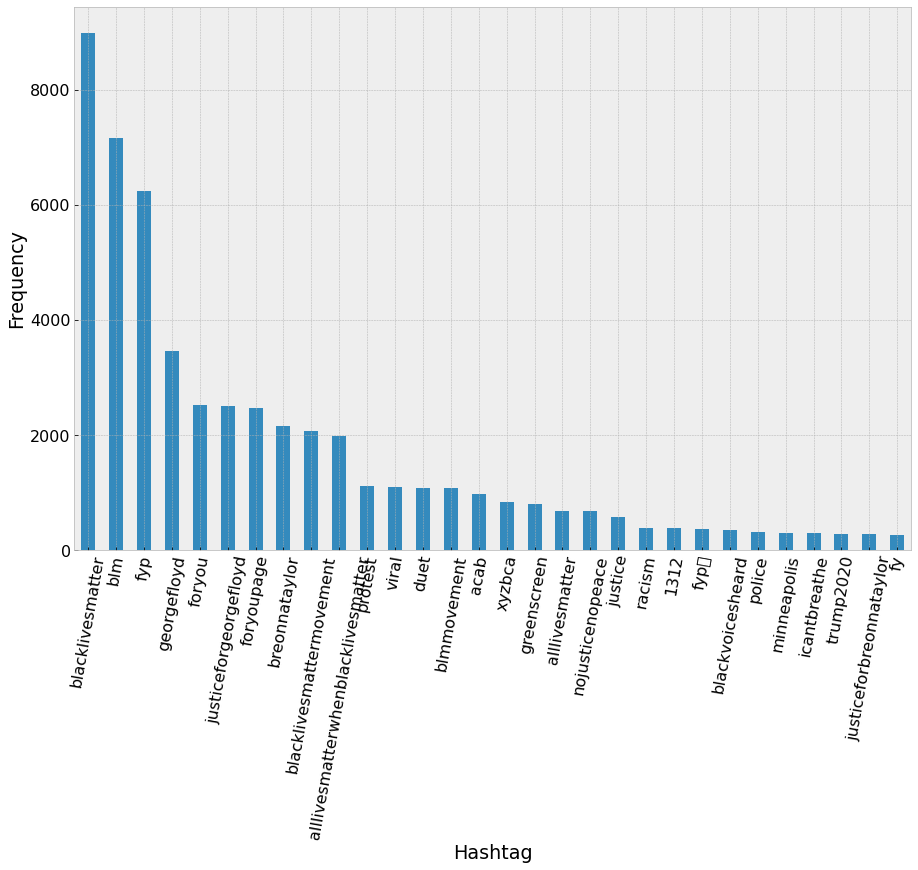

In [112]:
plt.figure(figsize=(15,10))
pro_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags related to pro BLM videos

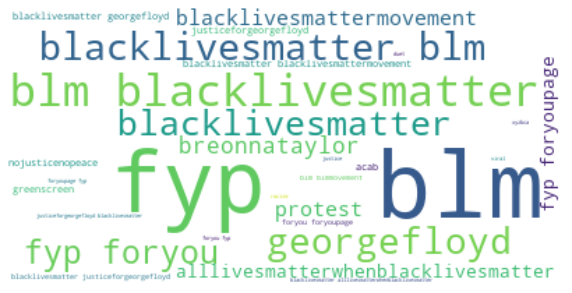

In [111]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(pro_hashtag_df['hashtag']))
wordcloud.to_file("img/proBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Hashtags related to pro BLM videos, with seed hashtags removed

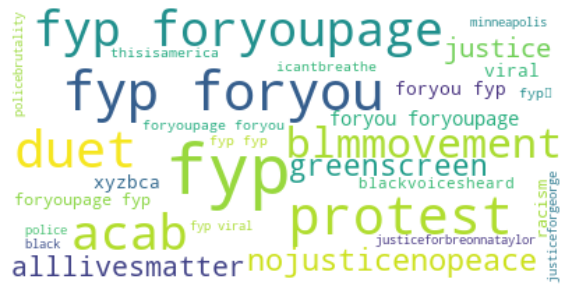

In [12]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(pro_hashtag_df[~pro_hashtag_df.hashtag.isin(hashtags_pro)].hashtag))
wordcloud.to_file("img/proBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Con Videos

In [13]:
con_hashtag_df = make_hashtag_dataframe(all_hashtag[all_hashtag.leaning < 0])

In [14]:
print('Number of unique hashtags used by "con BLM" users: ', len(con_hashtag_df.hashtag.unique()))

Number of unique hashtags used by "con BLM" users:  8987


### What are the most frequent hashtags connected to con BLM hashtags?


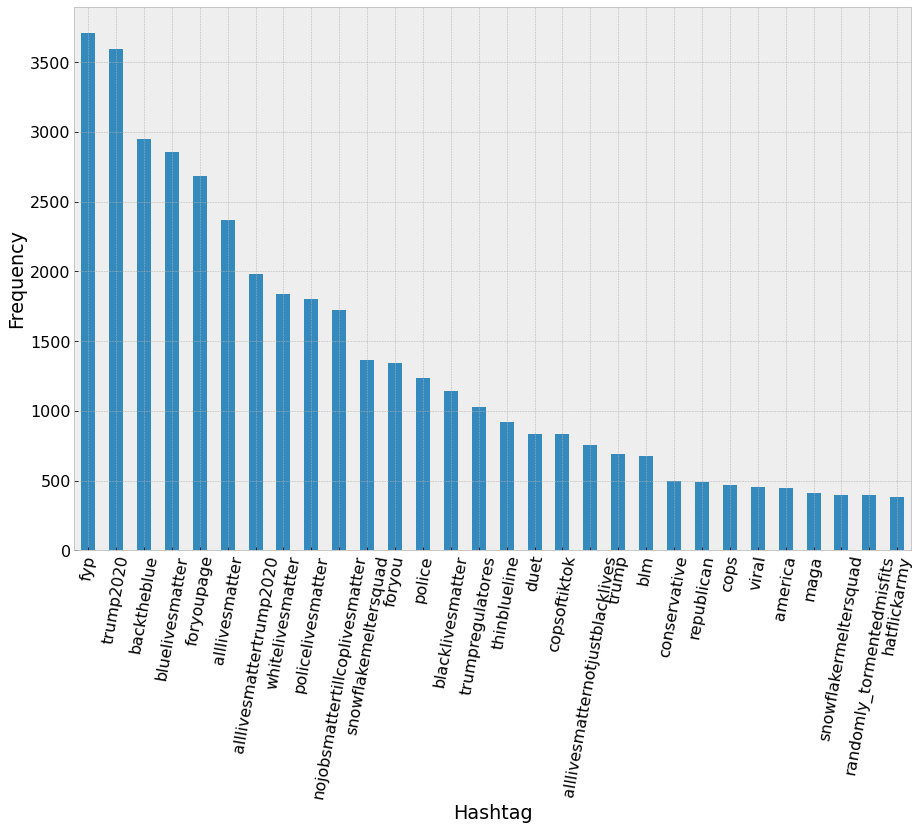

In [110]:
plt.figure(figsize=(15,10))
con_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags related to con BLM videos

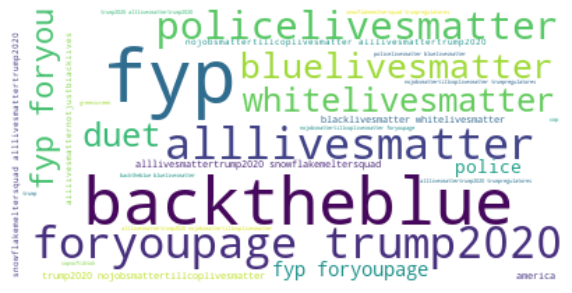

In [16]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(con_hashtag_df.hashtag))
wordcloud.to_file("img/conBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Hashtags related to con BLM videos, with seed hashtags removed

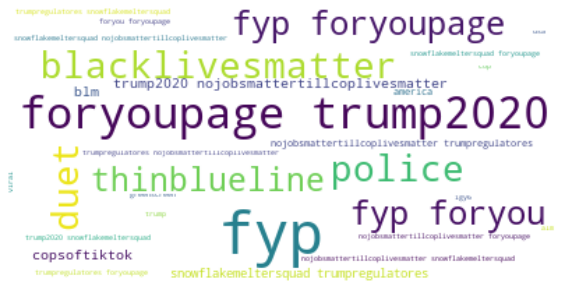

In [24]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(con_hashtag_df[~con_hashtag_df.hashtag.isin(hashtags_con)].hashtag))
wordcloud.to_file("img/conBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### unclassified (mid) videos

In [18]:
mid_hashtag_df = make_hashtag_dataframe(all_hashtag[all_hashtag.leaning == 0])

In [19]:
print('Number of unique hashtags used by unclassified users: ', len(mid_hashtag_df.hashtag.unique()))

Number of unique hashtags used by unclassified users:  1597


### What are the most frequent hashtags connected to unclassified hashtags?

/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0, flags=flags)


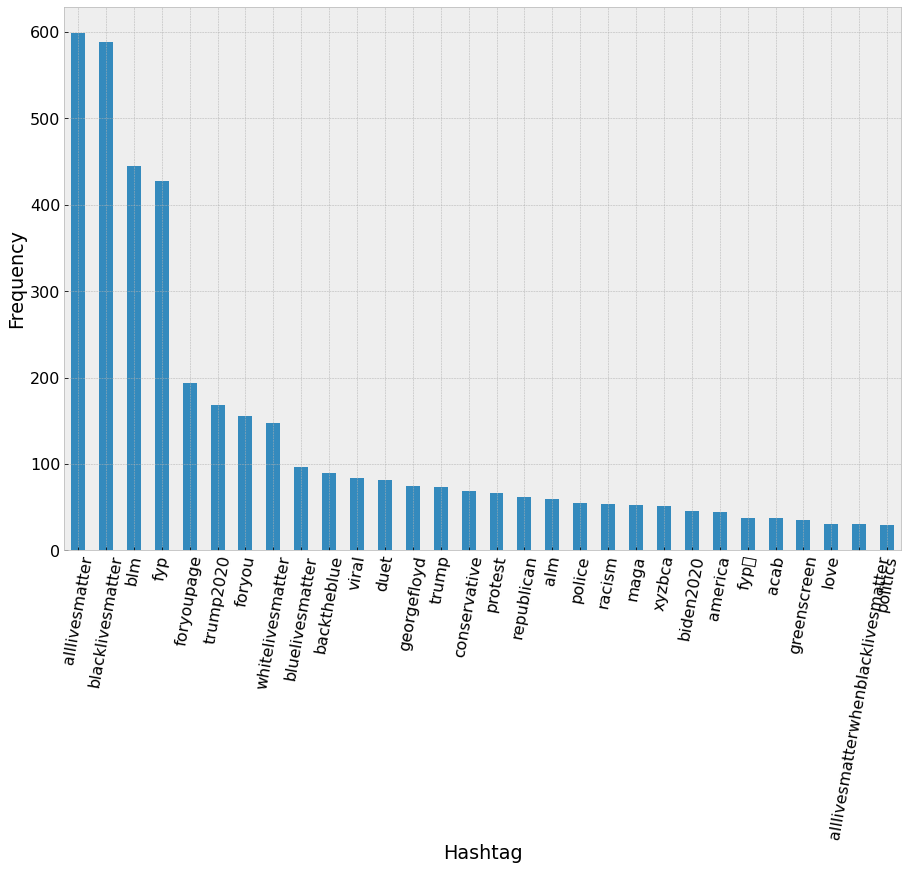

In [113]:
plt.figure(figsize=(15,10))
mid_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags used by unclassified users

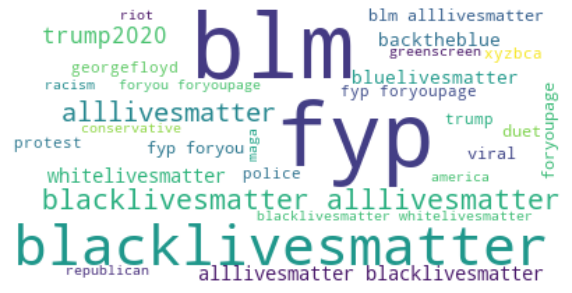

In [21]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(mid_hashtag_df.hashtag))
wordcloud.to_file("img/midBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### with seed hashtags removed

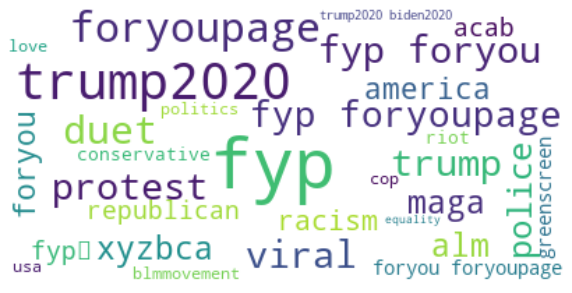

In [23]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(mid_hashtag_df[~mid_hashtag_df.hashtag.isin(hashtags_con+hashtags_pro)].hashtag))
wordcloud.to_file("img/midBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### all videos

In [25]:
all_hashtag_df = make_hashtag_dataframe(all_hashtag)

In [26]:
all_hashtag_df.shape

(168822, 3)

In [27]:
print('Number of unique hashtags in the dataset: ', len(all_hashtag_df.hashtag.unique()))

Number of unique hashtags in the dataset:  16623


### What are the most frequent hashtags in all data?

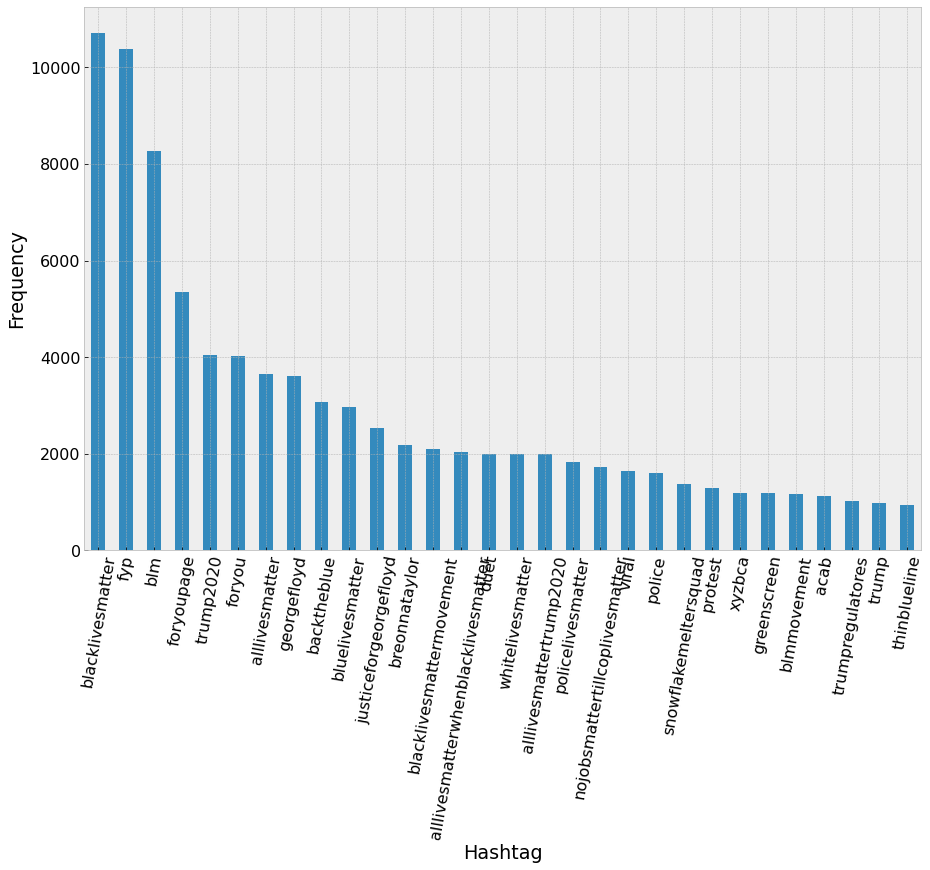

In [114]:
plt.figure(figsize=(15,10))
all_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags in the whole dataset

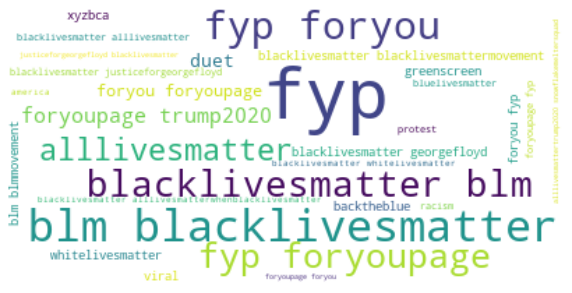

In [29]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(all_hashtag_df['hashtag']))
wordcloud.to_file("img/allBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
all_hashtag_df['hashtag'].value_counts().head(40)

blacklivesmatter                      10715
fyp                                   10376
blm                                    8276
foryoupage                             5356
trump2020                              4043
foryou                                 4032
alllivesmatter                         3660
georgefloyd                            3600
backtheblue                            3069
bluelivesmatter                        2972
justiceforgeorgefloyd                  2524
breonnataylor                          2172
blacklivesmattermovement               2091
alllivesmatterwhenblacklivesmatter     2034
duet                                   2004
whitelivesmatter                       1997
alllivesmattertrump2020                1988
policelivesmatter                      1828
nojobsmattertillcoplivesmatter         1722
viral                                  1636
police                                 1604
snowflakemeltersquad                   1367
protest                         

### Hashtags for the whole dataset, with pro and con seeds removed

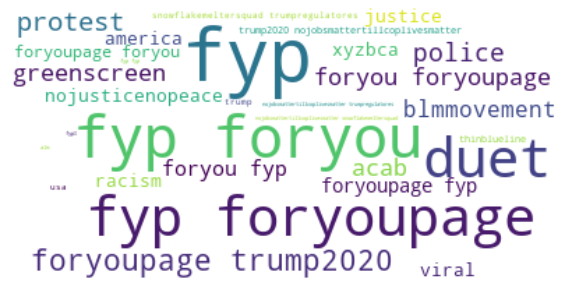

In [31]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(all_hashtag_df[~all_hashtag_df.hashtag.isin(hashtags_pro + hashtags_con)].hashtag))
wordcloud.to_file("img/allBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### no boosting tags or seed tags

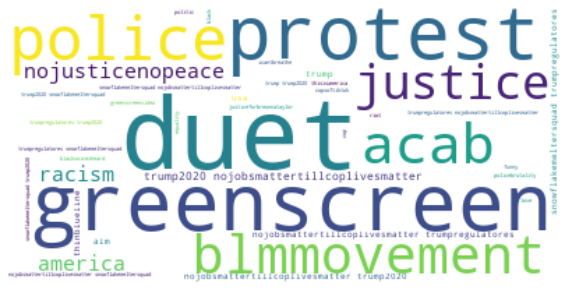

In [32]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=40, background_color="white").generate(' '.join(all_hashtag_df[~all_hashtag_df.hashtag.isin(hashtags_pro + hashtags_con + hashtags_boost)].hashtag))
wordcloud.to_file("img/allBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
all_hashtag_df[~all_hashtag_df.hashtag.isin(hashtags_pro + hashtags_con + hashtags_boost)].hashtag.value_counts().head(20)

trump2020                         4043
duet                              2004
nojobsmattertillcoplivesmatter    1722
police                            1604
snowflakemeltersquad              1367
protest                           1298
greenscreen                       1188
blmmovement                       1175
acab                              1119
trumpregulatores                  1029
trump                              976
thinblueline                       940
copsoftiktok                       872
nojusticenopeace                   700
conservative                       650
america                            640
republican                         637
justice                            629
cops                               604
racism                             548
Name: hashtag, dtype: int64

<center> <h2>Matching by sound</h2> </center>

### What are the most frequently used sounds that aren't original?

In [35]:
# TODO consider using what language original sound is classified as here as some proxy to foreign agents? 
# or maybe english as a second language speakers?

all_hashtag[~all_hashtag.music_title.isin(original_sound_dict)].music_title.value_counts().head(30)

Childish Gambino - This Is America / Post Malone - Congratulations    785
I NEED YOU TO                                                         404
Same Love (feat. Mary Lambert)                                        384
Mr Red White and Blue                                                 190
This Is America                                                       174
My Tears Are Becoming A Sea                                           108
Red Kingdom                                                            90
Surrender                                                              90
Officer Down                                                           75
オリジナル楽曲 - 🌏Samurai Tiktok🚀                                             58
Bad Boys (Theme From Cops)                                             56
"Go Go Go Who's Next?                                                  50
RIP Anthony Dia                                                        48
DJ Yames Mashup 6                     

### What are the most frequently used sounds in duets?

In [36]:
all_hashtag[(all_hashtag.duet_used == True) & (all_hashtag.nr_tags > 0)].music_title.value_counts().head(20)

original sound                                                        1110
Same Love (feat. Mary Lambert)                                          97
Childish Gambino - This Is America / Post Malone - Congratulations      34
Mr Red White and Blue                                                   12
Surrender                                                               11
I NEED YOU TO                                                           11
And thats on Black Lives Matter                                         10
RIP Anthony Dia                                                          9
Original Sound                                                           8
Right Back Where We Started From                                         8
Red Kingdom                                                              7
Magic In The Hamptons                                                    7
Worship Instrumental - Instrumental                                      6
Follow WOGASIANBRANDON   

### How many duets use original sound?

In [37]:
all_hashtag[(all_hashtag.duet_used == True) & (all_hashtag.nr_tags > 0) & (all_hashtag.music_title == 'original sound')].shape

(1110, 34)

### Are there some particular original sounds that are more popular in duets?

In [38]:
all_hashtag[(all_hashtag.duet_used == True) & 
          (all_hashtag.nr_tags > 0) & (all_hashtag.music_title == 'original sound')].music_id.value_counts().head(10)

6889175333107485446    8
6832735886413712133    6
6831679634426448645    6
6665542469326850822    6
6834966193955851014    6
6835463407244692230    6
6869460211468356358    6
6836924872862485254    5
6835345192418118406    5
6834302718052436742    5
Name: music_id, dtype: int64

### Extract the top 5 ids to search on them and get more data

In [39]:
all_hashtag[(all_hashtag.duet_used == True) & (all_hashtag.nr_tags > 0) & 
          (all_hashtag.music_title == 'original sound')].music_id.value_counts().head(5).index

Index(['6889175333107485446', '6832735886413712133', '6831679634426448645',
       '6665542469326850822', '6834966193955851014'],
      dtype='object')

### Get sound IDs for duets to search for more

In [40]:
duets_only = all_hashtag[all_hashtag.duet_used == True]

In [41]:
original_duets = duets_only[(duets_only.nr_tags > 0) & (duets_only.music_title == 'original sound')]

In [42]:
original_duets.shape

(1110, 34)

In [43]:
original_duets.to_csv('original_duets.csv')

### Get sound IDs for non-duets to search for more

In [44]:
all_hashtag[all_hashtag.music_title.isin(original_sound_dict)].shape

(15789, 34)

In [45]:
all_hashtag[all_hashtag.music_title.isin(original_sound_dict)].music_id.value_counts().head(10)

6822994590207970053    42
6806778141663693573    26
6863125506477378310    21
6832069493905312517    21
6816879324700920582    20
6833218151761578758    20
6811549095791020805    19
6835463407244692230    19
6719083048396147462    19
6665542469326850822    18
Name: music_id, dtype: int64

<center> <h2>Parsing videos matched by sound</h2> </center>

In [46]:
df_dict = {}

# Parsing all sound files
for file in os.listdir('/Users/andreasipka/Desktop/TikTok/data/sound'):
    if file.endswith('_sound.csv'):
        df_dict['sound_'+file[:-10]] = pd.read_csv('data/sound/'+file)
        df_dict['sound_'+file[:-10]] = parse_table_raw(df_dict['sound_'+file[:-10]], file[:-10])
        
# Merge what we have
all_sound = pd.concat(df_dict.values())

### How many videos are there in the search-by-sound data?

In [47]:
all_sound.shape[0]

35254

### How many of those used #duet hashtag?

In [48]:
all_sound[all_sound.duet_used == True].shape[0]

22755

In [49]:
all_sound[(all_sound.duet_used == True) & (all_sound.tagged_users != '')].shape[0]

22439

### Merging both datasets

In [138]:
data_complete = pd.concat([all_sound, all_hashtag])

In [139]:
data_complete.shape[0]

60948

In [140]:
np.setdiff1d(all_sound.columns, all_hashtag.columns)

array(['duetInfo', 'stickerText'], dtype=object)

In [141]:
np.setdiff1d(all_hashtag.columns, all_sound.columns)

array(['duetEnabled'], dtype=object)

### Leanings distribution for sound videos

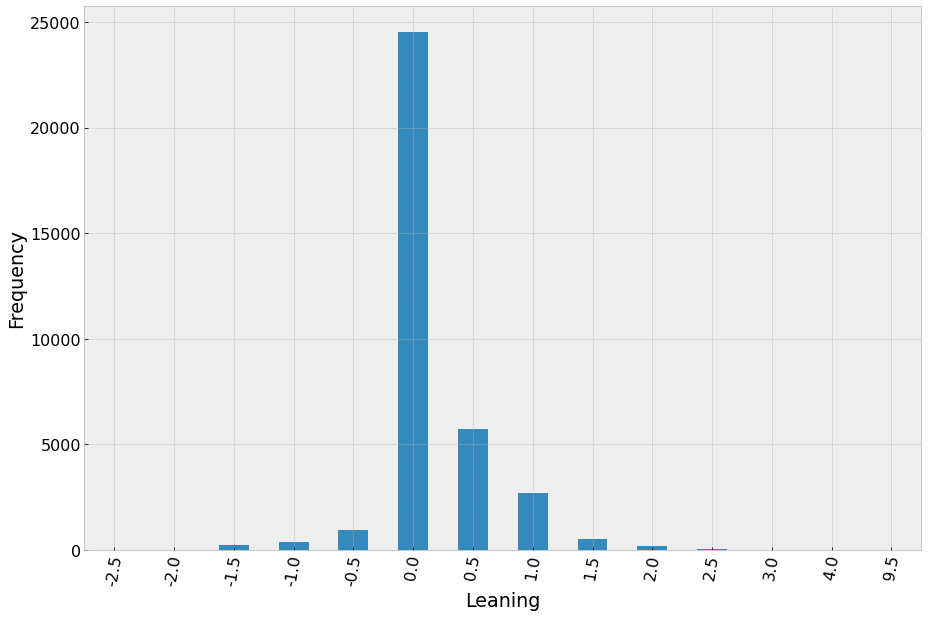

In [115]:
plt.figure(figsize=(15,10))
all_sound['leaning'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

### leanings distribution for hashtag videos

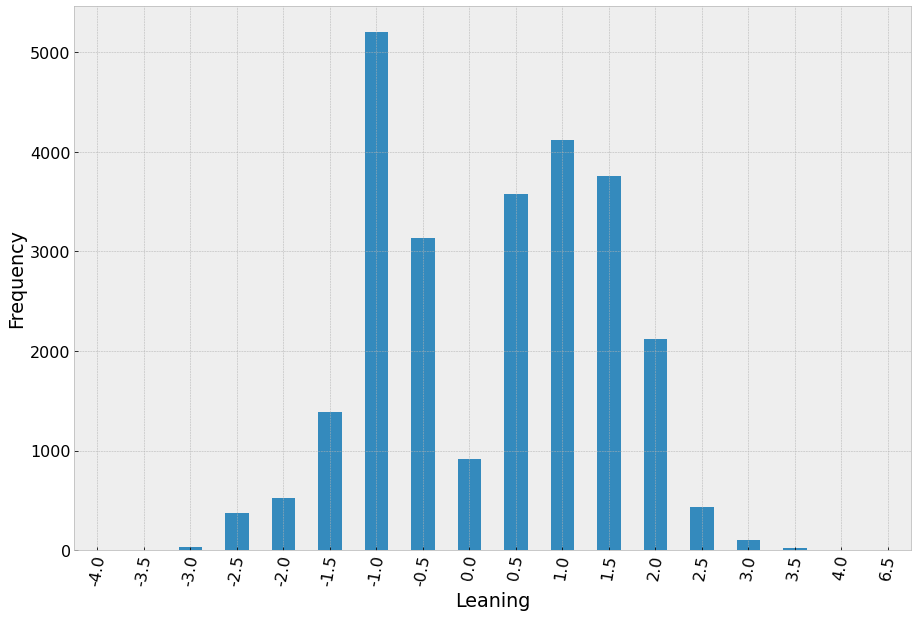

In [116]:
plt.figure(figsize=(15,10))
all_hashtag['leaning'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

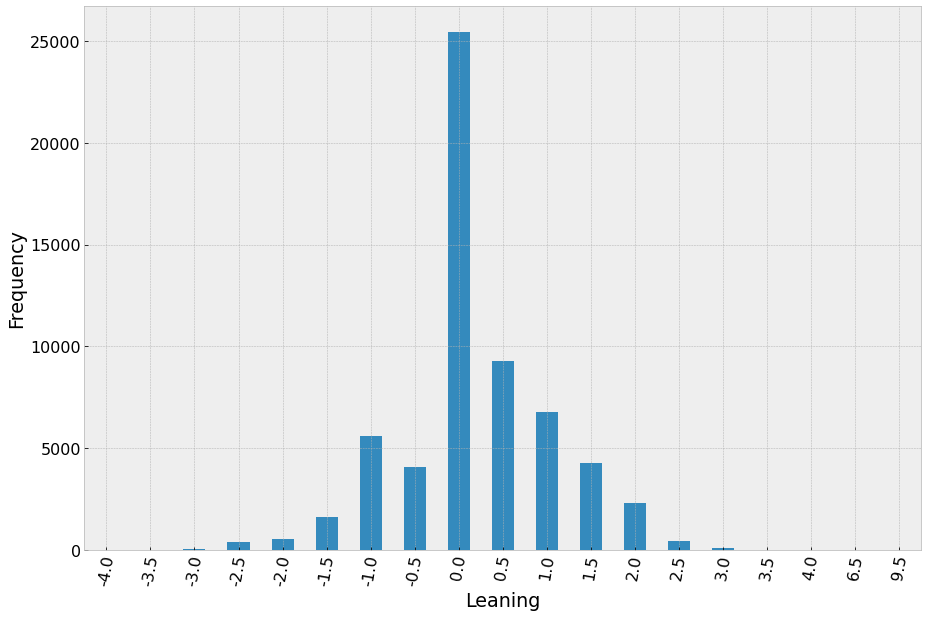

In [117]:
plt.figure(figsize=(15,10))
data_complete['leaning'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

<center> <h2>Pathetic attempts at graph exploration</h2> </center>

In [59]:
G = nx.Graph()

In [60]:
data_complete[(data_complete.duet_used == True) & (data_complete.nr_tags == 1)].shape

(23759, 36)

In [62]:
data_complete[(data_complete.duet_used == True) & (data_complete.nr_tags == 1)][['user_id', 'tagged_users']].head()

,user_id,tagged_users
1,6804890842937443334,6814185393371497478
2,6820171986931008517,6814185393371497478
3,6810892895605376005,6814185393371497478
5,6790081948297036805,6814185393371497478
6,6635722863121448966,6814185393371497478


In [63]:
G = nx.from_pandas_edgelist(data_complete[(data_complete.duet_used == True) & (data_complete.nr_tags == 1)][['user_id', 'tagged_users']], 'user_id', 'tagged_users')

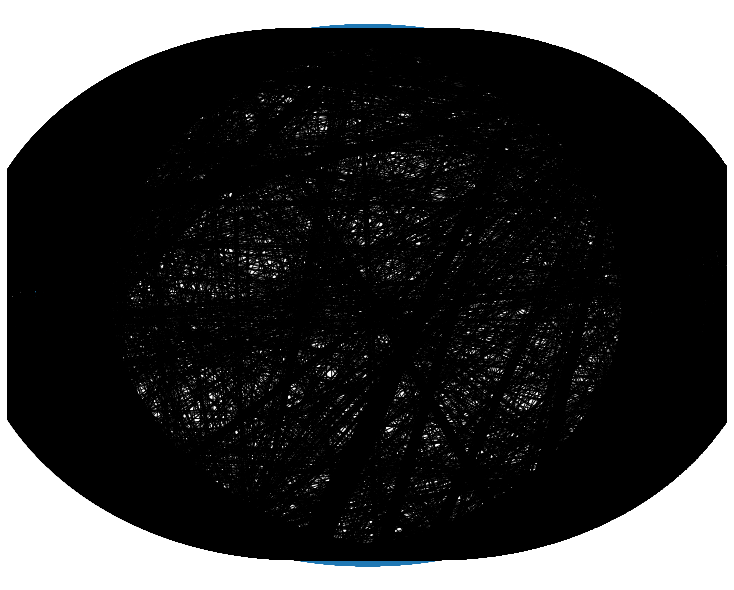

In [64]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [205]:
most_duets = {}

for x in G.nodes:
    most_duets[x] = len(G[x])
    
s = pd.Series(most_duets, name='no_duets')

s.to_frame().sort_values('no_duets', ascending=False)

,no_duets
150720527609769984,532
6780384192099435525,434
4653183,401
6645855783803191302,399
59240913742348288,384
...,...
6824633673402434565,1
6758986642666832901,1
75495950164594688,1
26881583,1


In [66]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 22527
Number of edges: 23522
Average degree:   2.0883


### How many videos do we have without hashtags?

In [91]:
data_complete[data_complete.nr_hashtags == 0].shape[0]

2802

In [181]:
data_complete[data_complete.nr_hashtags == 0].sample(10)

,duetInfo,video_id,video_desc,video_time,stitchEnabled,shareEnabled,isAd,stats_likes,stats_shares,stats_comments,stats_plays,video_length,user_id,user_name,user_signature,user_verified,music_id,music_title,music_author,music_original,authorstats_following,authorstats_followers,authorstats_heart,authorstats_videos,authorstats_diggs,nr_hashtags,hashtags_used,nr_tags,tagged_users,duet_used,stickerText,video_link,leaning,rank,obtained_via,duetEnabled
293,6.834209e+18,6834278171093847302,@mr.wyeet Please always go watch the original & like & share it. Stay Safe,1591229387,True,True,False,2,,,18,3,6711189371679196166,love_life_cosplay666,16+ Account | Duets +18n23 | She/her | bi/pannPhotographer | CosplayernAussie,False,6834209053837626117,original sound,Wyatt-chan,True,66,154,23700,78,8170,0,,1,6645855783803191302,,'Please always \ngo watch the \noriginal & like \n& share it ',https://www.tiktok.com/@love_life_cosplay666/video/6834278171093847302?lang=en,0.0,293,6834209053837626117,NaN
269,0.000000e+00,6866909272299670789,Don’t ever Hit a Women Period !!😪🙏🏻🙏🏻,1598826916,True,True,False,823,16,44,6360,1,6689561772570297349,teddy_1963,My Fans are the greatest!!! Thank you guys!🙏🏻🙏🏻💯Teddy_daytona 👻,False,6741910463438654213,original sound,victorilynntondre3,True,3,20260,760800,10,21,0,,0,,,"'Dont ever hit my Sister!!! ', 'Or Any other women PERIOD!!'",https://www.tiktok.com/@teddy_1963/video/6866909272299670789?lang=en,0.0,269,6741910463438654213,NaN
277,0.000000e+00,6841196069057989893,my reaction to this,1592840087,True,True,False,,,,,5,6831352040220869637,laynabrown2,🤗 13 nand I do mostly gacha,False,6832355525271751430,original sound,Jalen Taylor,True,135,17,577,13,885,0,,0,,,'my reaction to this',https://www.tiktok.com/@laynabrown2/video/6841196069057989893?lang=en,0.0,277,6832355525271751430,NaN
383,0.000000e+00,6842225774813138178,,1593079834,True,True,False,,,,2,1,6806613431207166978,sonicmlbb,ha hatdog hahahahaha,False,6839372645285464837,original sound,sasha,True,13,7,608,10,110,0,,0,,,,https://www.tiktok.com/@sonicmlbb/video/6842225774813138178?lang=en,0.0,383,6839372645285464837,NaN
53,6.832683e+18,6833085744559508741,[@alluringskull] This has also been proven through the ex wife of one of the undercover cops who started looting,1590951754,True,True,False,42,1,,184,1,192960647075295232,saltedcosplay,❄Salt Queen❄n25 - She/Her - OH cos n☕ 18+ for shipsn@cryptidcrow 💕,False,6832682979635088134,original sound,Jory & Max,True,80,2060,216900,114,9670,0,,1,6611200058774274054,,,https://www.tiktok.com/@saltedcosplay/video/6833085744559508741?lang=en,0.0,53,6832682979635088134,NaN
417,0.000000e+00,6839483142789745926,True,1592441272,True,True,False,,,,4,1,6718891532436571141,itzzximens469,I have 257 kids in my basement 💘💘,False,6809419747159968518,original sound,Jackyboy,True,67,25,6891,70,2140,0,,0,,,,https://www.tiktok.com/@itzzximens469/video/6839483142789745926?lang=en,0.0,417,6809419747159968518,NaN
205,0.000000e+00,6833121995769580806,,1590960193,True,True,False,87,,,1070,1,83338917646639104,trixi_inked_official,>>PAN<< ✌🏻🏳️u200d🌈n#mongowillinThanks for 76k Follower 🥺 & 3M likes. 🥺,False,6665542469326850822,original sound,thouseefmp,True,107,7630,3000000,247,2410,0,,0,,,,https://www.tiktok.com/@trixi_inked_official/video/6833121995769580806?lang=en,0.0,205,6665542469326850822,NaN
281,0.000000e+00,6887402407043534086,,1603598376,True,True,False,79,1,3,567,1,6612923236857348101,lucid_bull,🇺🇸Trump 2020 🇺🇸 nIf you don’t like it Unfollow and block me it’s not hard,False,6838068778064972550,original sound,Nate Johnson,True,502,15610,1300000,82,9910,0,,0,,,,https://www.tiktok.com/@lucid_bull/video/6887402407043534086?lang=en,0.0,281,6838068778064972550,NaN
27,0.000000e+00,6843902118861065477,NOT MY AUDI,1593470138,True,True,False,17,,,117,1,6781770182210749445,skinnygamingg,Pewdiepies doppelgängernMature audiences onlynNew video is up on my YT click ☝🏻,False,6843617123839789830,original sound,Eric Gramer,True,29,6950,1800000,85,1880

In [105]:
print(data_complete[data_complete.video_id == '6846792063888035078'].video_link.values)

['https://www.tiktok.com/@edwardboyett49/video/6846792063888035078?lang=en']


<center> <h2>Dealing with video descriptions</h2> </center>

In [198]:
vids_with_desc = data_complete[data_complete.video_desc != '']

In [204]:
vids_with_desc.shape

(59658, 45)

In [199]:
do_counts(vids_with_desc)

In [200]:
# Add columns for values to be stored
vids_with_desc['video_desc_cleaned'] = vids_with_desc['video_desc']
vids_with_desc['num_emoji'] = 0
vids_with_desc['video_desc_nostop'] = ''

vids_with_desc = vids_with_desc.apply(clean_text, axis=1)

In [197]:
vids_with_desc[['video_desc', 'num_emoji', 'upper', 'video_desc_cleaned']].sample(20)

,video_desc,num_emoji,upper,video_desc_cleaned
79,#duet with @iambigkens get this piece of shit #acab #1312 #georgefloyd#blm,0,0,get this piece of shit
1223,Just in case you forgot. #fyp #foryou #blacklivesmatter #blm #breonnataylor #georgefloyd #blmmovement #protest #viral,0,0,just in case you forgot
1383,#duet with @alliyahhedwardss #blacklivesmatter #blmmovement #blm2020movement #blacklivesmatters #blacklivesmattermovement,0,0,
1711,someone help me pack i’m moving to outer space #SpaceForceWalk #gardening101 #maincharacter #fyp #rednecks #georgefloyd,0,0,someone help me pack i m moving to outer space
266,#duet with @574whitegirl,0,0,l
67,#duet with @thequeerkiwi,0,0,i
1377,@ktla5 Meets #SMN74 😳🔥 FOR MY SKIN COLOR AND MY PEOPLE ✊🏾#blacklivesmattter #peacefulprotest #georgefloyd #breonnataylor #HealthyLiving #nn74,4,8,ktla meets for my skin color and my people
855,proud patriotic conservative who backs the blue🤷🏼‍♀️🚂🇺🇸❤️🤍💙 happy 4th to the best country in the world #backtheblue #conservative #trump2020,0,0,proud patriotic conservative who backs the blue happy th to the best country in the world
36,You guys need to keep sharing her video this needs to be heard😔 #duet with @jackiekamel #blm #blacklivesmatter #acap,0,0,
1883,This is messed up but it’s also p funny🥺 #fyp #johnnysins #blm #justiceforgeorgefloyd,0,0,this is messed up but it s also p funny
